### Example Notebook to bench test all the pieces and make improvements for tuning repeatability. Also should serve as a first order walkthrough of the process for demonstrations (Results may vary)

##### Probabalistic Demonstration of A Bayesian Changepoint analysis, Inncluding a rudimentary correlation and forecasting solutions

#### Goals:
##### Take a number of input well logs, from a geoligically similar basin and analyse them by identifying changepoints and data trends that will be used to interprete property changes and characterize the subsurface. Follow by simulating a drilling campaign

#### Outline: 
##### Volve Dataset will be used as a test case of the analysis, 5 wells have been drilled in the north sea Volve field offshore of southern Norway. This notebook will try to forcast the probability of property changes from a hypothetical drilling campaign, while drilling. Simulated by incremetally adding data to the analysis from a known well.

###### Some background info... and nomenclature. I've decided to use the vernacular 'CompariTEE' and 'CompariTOR' to describe the Unknown and known wells, if only to capitalize on the neumonic *Prior/Tor* it really could have gone either way.

###### Comparitor ('priors') wells: 15-9: F1, F1A, F1B, F1C, F11B, F11T2 
###### Comparitee (investigation) wells: 15-9-F11A 


###### adam jones 05.07.23

In [81]:
'''Loading dependencies''' 
import sys
sys.path.append('..\\..\\src')

import matplotlib.pyplot as plt
import numpy as np
#import ruptures as rpt
import welly
import pandas as pd
import scipy.stats as stats

#Collections of self built methods
import cp_comparitor as cp_Comp
import change_point_tools as cp_Tools
import well_tools as wtool

# This is testing module
import test_func as tst

In [82]:
# OS well path 
#path = 'C:\\Users\\ada55080\\git\different_bayes\\volve_well_data\\'
path = '..\\..\\data\\raw\\volve_well_data\\'

##### Loading Wells into memory, Volve wells 15-9: F1, F1A, F1B, F1C, F11B, F11



In [83]:
# These are pretty well groomed but lack some spatial data (TVD, Lat/Long, etc...)

f1 = welly.Well.from_las(path + '15_9-F-1\\15_9_F1_complete.las')
f1A = welly.Well.from_las(path + '15_9-F-1A\\15_9-F-1A.las')
f1B = welly.Well.from_las(path + '15_9-F-1B\\15_9-F-1B.las')
f1C = welly.Well.from_las(path + '15_9-F-1C\\15_9-F-1C.las')
f11A = welly.Well.from_las(path + '15_9-F-11A\\15_9-F-11A.las')
f11B = welly.Well.from_las(path + '15_9-F-11B\\15_9-F11B.las')

##### The following dictionaries are place holder variables.

In [84]:

#Rolling average parameters

# window = 30
# periods = 3

# setting global variables for the ruptures PELT parameters pen and min_size 
# RHOB_glob_pen = 0.5
# RHOB_glob_min = 10

# NPHI_glob_pen = 0.1
# NPHI_glob_min = 10

# GR_glob_pen = 1300
# GR_glob_min = 10


# string label varables'
# dataGR = "GR"
# dataRHOB = "RHOB"
# dataNPHI = "NPHI"

#Well names lists for automation
_wellnames = ['df_f1','df_f1A', 'df_f1B', 'df_f1C', 'df_f11A', 'df_f11B']
_wells = [f1, f1A, f1B, f1C, f11A, f11B]
_log_list = ['NPHI','RHOB','GR','DT','PEF']
_log_list_GR = ['GR']
_log_list_nodt = ['NPHI','RHOB','GR']


# Dictionaries for well extents in meters below surface, these extents are mostly consistent and exist for all input logs

_logname_extent_min = {'f1': 2620 ,'f1A' : 2620, 'f1B' : 3100 , 'f1C': 3100 , 'f11A' : 2600 , 'f11B': 3200 }
_logname_extent_max = {'f1': 3590 ,'f1A' : 3600, 'f1B' : 3400 , 'f1C': 4100 , 'f11A' : 3700 , 'f11B': 4550 }
_log_extent_min = {0 : 2620, 1 : 3100 , 2: 3100 , 3 : 2600 , 4: 3200 }
_log_extent_max = {0: 3600, 1 : 3400 , 2: 4100 , 3 : 3700 , 4: 4550 }


##### Loading Volve Well logs... These logs do not have any spacial awareness so everthing is relative to the Measured Depth
######  in the borehole future implementations will need some 3D awareness to be convincing, as these particular wells are controlled for depth and are clearly in the same basin they can work for this illustration

In [85]:
# Writing well log values to dataframe, index is MD(measured depth)

df_f1 = _wells[0].df(_log_list)
df_f1A = _wells[1].df(_log_list)
df_f1B = _wells[2].df(_log_list)
df_f1C = _wells[3].df(_log_list)
df_f11A = _wells[4].df(_log_list)
df_f11B = _wells[5].df(_log_list)

df_f1clip = df_f1[_logname_extent_min['f1']:_logname_extent_max['f1']]
df_f1Aclip = df_f1A[_logname_extent_min['f1A']:_logname_extent_max['f1A']]
df_f1Bclip = df_f1B[_logname_extent_min['f1B']:_logname_extent_max['f1B']]
df_f1Cclip = df_f1C[_logname_extent_min['f1C']:_logname_extent_max['f1C']]
df_f11Aclip = df_f11A[_logname_extent_min['f11A']:_logname_extent_max['f11A']]
df_f11Bclip = df_f11B[_logname_extent_min['f11B']:_logname_extent_max['f11B']]


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\cu

In [86]:
#DataFrames with rolling averages to demonstrate their... limited 'usefulness'


df_f1A_roll = _wells[1].df(_log_list)
data_f1A = wtool.compute_all_rolling_avg(df_f1A_roll, window=30, periods=3)

#data_f1B = wtool.compute_all_rolling_avg(df_f1B, window=30, periods=3)
# data_f1C = wtool.compute_all_rolling_avg(df_f1C, window=30, periods=3)
#data_f11A = wtool.compute_all_rolling_avg(df_f11A, window=30, periods=3)
# data_f11B = wtool.compute_all_rolling_avg(df_f11B, window=30, periods=3)

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


#### Ploting all the input well dataframes to check everything is organized correctly

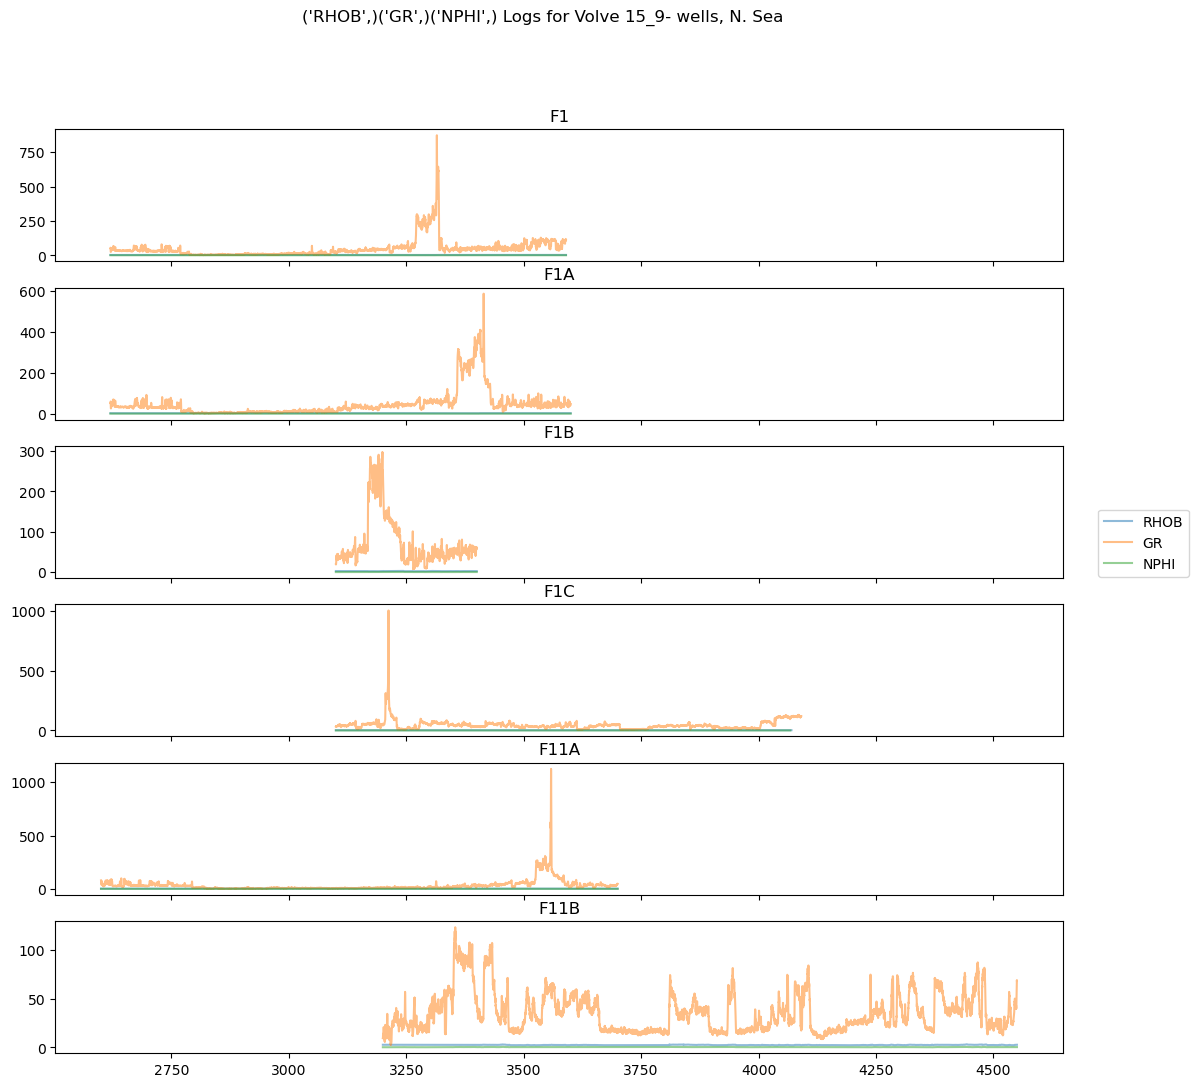

In [87]:

log = ['RHOB', 'GR', 'NPHI']

lognames = ''
for i in zip(log): lognames += str(i)
fig, ax = plt.subplots(6, figsize=(13,12), sharex=True)
fig.suptitle(lognames+' Logs for Volve 15_9- wells, N. Sea')
ax[0].plot(df_f1clip[log], label=log, alpha=0.5)
ax[0].set_title('F1')
ax[1].plot(df_f1Aclip[log], alpha=0.5)
ax[1].set_title('F1A')
ax[2].plot(df_f1Bclip[log], alpha=0.5)
ax[2].set_title('F1B')
ax[3].plot(df_f1Cclip[log],alpha=0.5)
ax[3].set_title('F1C')
ax[4].plot(df_f11Aclip[log], alpha=0.5)
ax[4].set_title('F11A')
ax[5].plot(df_f11Bclip[log], alpha=0.5)
ax[5].set_title('F11B')
fig.legend(loc='center right')

##### Automation functions that corrects for missing or incomplete data before attempting change point analysis

In [8]:
# Working methods to automate the data grooming and change point detection procedure

def insert_array_to_dataframe(dataframe, array, column_name, index, idx_array):
    """
    Inserts the provided array as a new column in the DataFrame at the specified index.

    Parameters:
        dataframe (pd.DataFrame): The original DataFrame.
        array (array-like): The array to be inserted as a new column.
        column_name (str): The name of the new column to be created.
        index (int): The index where the new column should be inserted.

    Returns:
        pd.DataFrame: The modified DataFrame with the new column inserted.
    """

    # First, convert the array to a pandas Series with appropriate index
    series = pd.Series(array, index=idx_array)

    # Check if the index is within the valid range of the DataFrame
    #if index < 0 or index > len(dataframe.columns):
    #    raise IndexError("Index is out of range.")

    # Split the DataFrame into two parts at the specified index
    left_part = dataframe.iloc[:, :index]
    right_part = dataframe.iloc[:, index:]

    # Insert the new column into the DataFrame
    dataframe = pd.concat([left_part, series.rename(column_name), right_part], axis=1)

    return dataframe

# # Example usage:
# # Create a sample DataFrame
# data = {
#     'A': [1, 2, 3, 4, 5],
#     'B': [10, 20, 30, 40, 50],
#     'C': [100, 200, 300, 400, 500]
# }
# df = pd.DataFrame(data)

# # Example array and column name
# array_to_insert = [1000, 2000, 3000, 4000, 5000]
# column_name_to_insert = 'D'
# index_to_insert = 2

# # Insert the array into the DataFrame at the specified index with the specified column name
# df = insert_array_to_dataframe(df, array_to_insert, column_name_to_insert, index_to_insert)

#print(df)

    '''
    This is a helper function will groom the ends (by holding values) and remove NaN's of an
     incomplete dataset and perform a Bayesian changepoint search.

     results of the search will be added to another row of the dataframe.

     Really should be building a well 'object' that holds this data along with the
     trends and correlation to other wells, but for now it is a dataframe... added to cp_Comparitor.py

    '''


def df_add_CP_Prob(df, start, stop, log_dict=[], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=1000, **kwargs):
    ''' Adds a probability curve for change points to a dataFrame
    
    Parameters:
        df (pandas.Dataframe) : input dataFrame with a dataset mentioned in the log_dictionary 
        log_dict (dict) :  Log dictionary
        label (str)  : Prefix for probability curve that will be appended to the dataFrame
        
        **passthrough argument for replace_nans function**
        nan_method (str) : choices ('global_average', 'local_average', 'linear_interpolation') 
        window_size (int) : window size for calculating local averages.
    
        segment_length (int) : split for offline Bayesian Change Point detection,
                                unsefult to control the computational cost of this function

    Returns: None, this merely adds a curve to the input dataframe

    '''
    
     #Keyword Args assingment
    _prior = kwargs.get('prior') # choices are "const", "geometric", "neg_binomial"
    _method = kwargs.get('method')  # choices are 'gauss', 'ifm' or 'full_cov'
    _engine = kwargs.get('engine')  # choices are "numpy" or "numba"
    _normalize = kwargs.get('normal')

    #Argument Defaults
    if _method == None:
        _method = "full_cov"
    if _prior == None:
        _prior = "const"
    if _engine == None:
        _engine ="numba"
    #if _normalize == False:
    
    print(str(df))
    #Fill ends of incomplete df, replace NaN's with parameter method, and changepoint search with parameter segment splits
    for log in log_dict:
        print(' finding changepoints in '+log)
        labl = label+log
        df[log][start:stop] = wtool.fill_out_data_ends(df[log][start:stop].values)

        df[log][start:stop] = wtool.replace_nans(df[log][start:stop].values, method=nan_method, window_size=window_size)
        
        changepoint_prob = cp_Tools.bayes_offline_split(df[log][start:stop].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)
        
        log_index_array = df[log][start:stop].index
        d = {labl : pd.Series(changepoint_prob, index=log_index_array)}
        dfcp = pd.DataFrame(data=d) 
        df = pd.concat([df, dfcp], axis=1,)
        
    return df
        

In [9]:
''' ! ! ! AUCHTUNG ! ! !  ***** This cell will take a bit of time to compute, *****  

time for coffee break? or just take your eyes off the screen.

it took about 15 min with sequence_length=700 I have them individually commented for convenience
to reduce the compute time, reduce the _segment_length variable as this will lighten the computational load
'''

_log_list_ = ['GR', 'RHOB', 'NPHI']
_segment_length = 100 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency
_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals

df_f1clip = df_add_CP_Prob(df_f1clip, start=_logname_extent_min['f1'], stop=_logname_extent_max['f1'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

#cp_Comp.df_add_CP_Prob(df_f1A, start=_logname_extent_min['f1A'], stop=_logname_extent_max['f1A'], log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)
#cp_nphi =

df_f1A = df_add_CP_Prob(df_f1Aclip, start=_logname_extent_min['f1A'], stop=_logname_extent_max['f1A'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

df_f1B = df_add_CP_Prob(df_f1Bclip, start=_logname_extent_min['f1B'], stop=_logname_extent_max['f1B'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

#df_f1C = df_add_CP_Prob(df_f1B, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)#, normal=True)

#df_f1C = df_add_CP_Prob(df_f1Cclip, start=_logname_extent_min['f1C'], stop=_logname_extent_max['f1C'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

df_f11A = df_add_CP_Prob(df_f11Aclip, start=_logname_extent_min['f11A'], stop=_logname_extent_max['f11A'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

df_f11B = df_add_CP_Prob(df_f11Bclip, start=_logname_extent_min['f11B'], stop=_logname_extent_max['f11B'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

# #df_CP_Prob(df_f1A, log_dict=['GR'], label='CP_Prob_', method='local_average', window_size=_window_size, segment_length=_segment_length)

#### template ##### df_CP_Prob(df, log_dict=[], label='CP_Prob_', method='local_average', window_size=_window_size, segement_length=_segment_length)

# data = np.arange(1,100,1)
# ones = np.ones(50)
# df = pd.DataFrame(data, columns=['data'])
# df.insert(50, 'ones', ones)
# df.plot()



                         NPHI          RHOB              GR             DT   
DEPTH                                                                        
2620.0999999977  0.2612999997  2.5033000004   51.2662999780  76.8031999567  \
2620.1999999977  0.2775999996  2.4735000007   54.5096999270  79.2299999454   
2620.2999999977  0.2813999999  2.4374000008   54.8417999925  81.8259999416   
2620.3999999977  0.2701000003  2.3991000009   52.7658000467  84.3241999438   
2620.4999999977  0.2582000003  2.3666000007   47.5078001183  86.5840999491   
...                       ...           ...             ...            ...   
3589.5999999969  0.2207000001  2.6035000000  116.5063000734  81.2211000041   
3589.6999999969  0.2191000001  2.6035000000  113.0423001085  80.9112000097   
3589.7999999969  0.2179000000  2.6046000000  107.8736001619  80.4867000133   
3589.8999999969  0.2244999998  2.6053000000  107.1986000211  79.8841000189   
3589.9999999969  0.2220000001  2.6036000001  109.6029999247  79.

C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.fill_out_data_ends(df[log][start:stop].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.replace_nans(df[log][start:stop].values, method=nan_method, window_size=window_size)


/n finding changepoints in RHOB 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n finding changepoints in NPHI 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n                         NPHI          RHOB             GR             DT   
DEPTH                                                                       
2620.0999999977  0.2612999997  2.5033000004  51.7539999256  85.5393000115  \
2620.1999999977  0.2775999996  2.4735000007  53.4698999614  85.2690000061   
2620.2999999977  0.2813999999  2.4374000008  54.7367999715  84.9989000061   
2620.3999999977  0.2701000003  2.3991000009  56.0099999713  84.8673000030   
2620.4999999977  0.2582000003  2.3666000007  59.4637999223  84.9988999970   
...                       ...           ...            ...            ...   
3599.5999999969  0.1288999999  2.5771000003  44.3673999471  70.1850000016   
3599.6999999969  0.1259000001  2.5490000009  43.5794000248  70.3161999959   
3599.7

C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.fill_out_data_ends(df[log][start:stop].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.replace_nans(df[log][start:stop].values, method=nan_method, window_size=window_size)


/n finding changepoints in RHOB 9800 of 9800
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n finding changepoints in NPHI 9800 of 9800
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n                         NPHI          RHOB             GR             DT   
DEPTH                                                                       
3100.0999999973  0.0669000000  2.6294000000  19.3109000104  67.8433999920  \
3100.1999999973  0.0681000000  2.6295000000  18.9309000102  68.1850999908   
3100.2999999973  0.0690000000  2.6298000000  19.2299999920  68.5066999914   
3100.3999999973  0.0697000000  2.6300000000  19.3023999981  68.7442999936   
3100.4999999973  0.0706000000  2.6299000000  20.3277999724  69.0092999929   
...                       ...           ...            ...            ...   
3399.5999999970  0.1861000003  2.4570999999  60.4391999769  75.3947000023   
3399.6999999970  0.1840000001  2.4595999999  61.8451999584  75.3404000016   
3399.7

C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.fill_out_data_ends(df[log][start:stop].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.replace_nans(df[log][start:stop].values, method=nan_method, window_size=window_size)


/n finding changepoints in RHOB 3000 of 3000
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n finding changepoints in NPHI 3000 of 3000
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n                         NPHI          RHOB             GR              DT   
DEPTH                                                                        
2600.0999999978  0.3410000007  2.3380000004  79.3990000735  103.8270000171  \
2600.1999999978  0.3080000007  2.3150000005  74.2480001130  102.7400000238   
2600.2999999978  0.2830000005  2.2910000005  68.5420001252  100.9430000394   
2600.3999999978  0.2720000002  2.2690000005  60.3140001805   98.4730000542   
2600.4999999978  0.2660000001  2.2530000004  51.8950001847   97.1710000286   
...                       ...           ...            ...             ...   
3699.5999999968  0.2380000000  2.2330000000  44.9750000040   92.5889999935   
3699.6999999968  0.2399999999  2.2340000000  44.6350000109   92.8379999920

C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.fill_out_data_ends(df[log][start:stop].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.replace_nans(df[log][start:stop].values, method=nan_method, window_size=window_size)


/n finding changepoints in RHOB0: 11000 of 11000
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n finding changepoints in NPHI0: 11000 of 11000
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n                         NPHI          RHOB             GR           PEF
DEPTH                                                                   
3200.0999999973  0.0769999999  2.6020000001   9.3619999996  7.4639999996
3200.1999999973  0.0780000000  2.5990000001   9.5449999950  7.4050000016
3200.2999999973  0.0790000000  2.5940000001  11.1529999560  7.2920000031
3200.3999999973  0.0780000000  2.5890000001  12.5919999606  7.1670000034
3200.4999999973  0.0750000001  2.5870000001  12.6439999986  7.0670000027
...                       ...           ...            ...           ...
4549.5999999960  0.1979999998  2.5619999994  62.6629999327  5.8009999960
4549.6999999960  0.1990000000  2.5759999994  64.5869999237  5.8729999971
4549.7999999960  0.2000000000  2.58499

C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.fill_out_data_ends(df[log][start:stop].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1411420690.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log][start:stop] = wtool.replace_nans(df[log][start:stop].values, method=nan_method, window_size=window_size)


/n finding changepoints in RHOB0: 13500 of 13500
method- full_cov, prior- const, engine- numba
Segmenting into 100
/n finding changepoints in NPHI0: 13500 of 13500
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nmpleted segment 135 from 13400: 13500 of 13500

##### Tuning cell to establish the best parameters for the changepoint search method, many real datasets require it.

In [66]:
# df = df_f1B 
# log='RHOB'
# labl='CP_prob_test'
# nan_method = 'local_average'
#window_size= 100
#_method ='full_cov'
#_prior = 'const'
#_engine = 'numba'
#segment_length = 600
#_normalize = True

# df[log] = wtool.fill_out_data_ends(df[log].values)

# df[log] = wtool.replace_nans(df[log].values, method=nan_method, window_size=window_size)
        
# np.where(np.isnan(df[log].values)) # reports data gaps 
#cp_prob = cp_Tools.bayes_offline_split(df[log][_logname_extent_min['f1B']:_logname_extent_max['f1B']].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)



method- full_cov, prior- const, engine- numba
Segmenting into 600
/nmpleted segment 5 from 2400: 3000 of 3000

##### Segment lengths for the changepoint detection have sunstantial influence on the posterior probability curve

###### Where this effect is less pronounced in datasets with more variance, there are some sequences with obvious shifts that are not recognized by the algorithm unless the prior data sufficiently encapsulates the data variance from within multiple changes within the data. This limitation demands that to some extent, tuning is required to best characterize the probabilties found with this method so as to avoid false positives or build additional confidence factors

###### In a practical sense, this tuning could be derived stochastically or by way of weighting change points found in this method with other discrete change point methods, such as PELT, or by evaluating the likeliness with a focused single change point method.  But, these will further add to the computational cost for analysis.



In [14]:
''' This cell will take quite some time to compute, 60+ minutes in previous attempts

It will compute the probability of a normalized curve for change points in the dataset, and this is used to display the
relative importance for tuning the Bayesian changepoint algorithm for not only completeness of the solution i.e. find all 
the useful changepoints, but also to not "overspend" on the computing time to achieve this.

As a practical limitation for the framework, a great deal of this computation time can be handled in a step before the
active analysis of input data, but this step will grow proportionally with the increase in input data.'''

#df_f1clip[['CP_Prob_RHOB','CP_Prob_PEF']].plot(alpha=0.7)
#plt.plot(cp_Tools.normalize_array(df_f1clip['PEF'],0,0))
#PEF_seg_1000 = cp_Tools.bayes_offline_split(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), segment_length=1000, method='full_cov', prior='const', engine='numba', normal=True)

#PEF_seg_3000 = cp_Tools.bayes_offline_split(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), segment_length=3000, method='full_cov', prior='const', engine='numba', normal=True)

PEF_seg_6000 = cp_Tools.bayes_offline_split(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), segment_length=6000, method='full_cov', prior='const', engine='numba', normal=True)

PEF_ = cp_Tools.bayes_offline_sdt(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0), method='full_cov', prior='const', engine='numba', normal=True)

method- full_cov, prior- const, engine- numba
Segmenting into 6000
/nmpleted segment 2 from 6000: 9700 of 9700

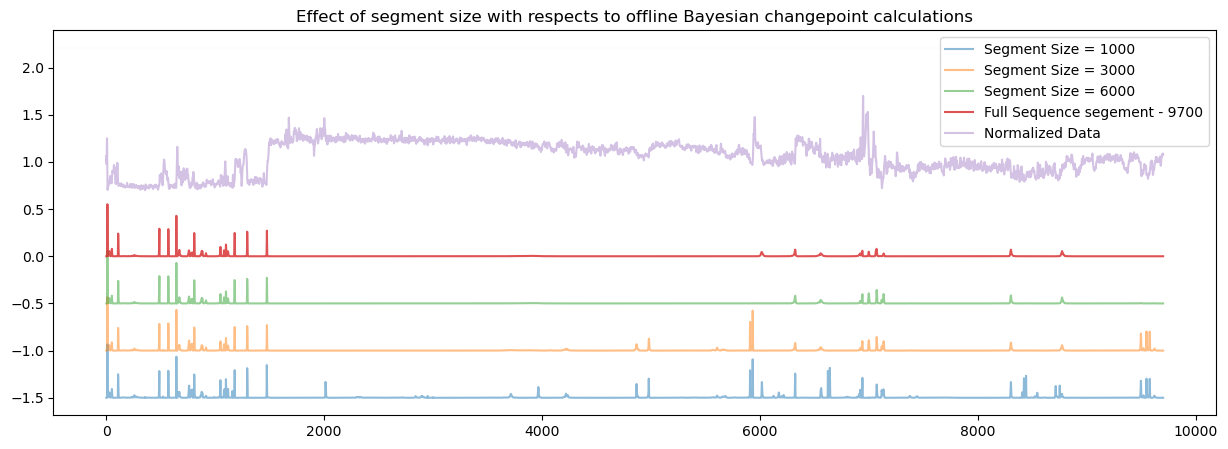

In [ ]:
# Plotting the resuts from the cell above

plt.figure(figsize=(15,5))

plt.plot(PEF_seg_1000-1.5, alpha=0.5, label='CP Probability Segment Size = 1000')
plt.plot(PEF_seg_3000-1, alpha=0.5, label='CP Probability Segment Size = 3000')
plt.plot(PEF_seg_6000-.5, alpha=0.5, label='CP Probability Segment Size = 6000')
#plt.plot(cp_Tools.normalize_array(df_f1clip['PEF'],0,0))
plt.plot(PEF_, alpha=0.8, label='Full Sequence CP Probability Segment = 9700')
plt.plot(cp_Tools.normalize_array(df_f1clip['PEF'].values,0,0)+.7, alpha=0.4, label='Normalized Data')
plt.legend(loc='upper right')
plt.axhline(2.21, alpha=.01)
plt.title('Effect of segment size on offline Bayesian changepoint calculations');

##### There is also a question of noise reduction, for example by computing the rolling average of a dataset.
###### a rolling average is often used to deconvolute the data so that changepoints are less obscured ba them, but it seems that the Offline Bayesian search function is quite robustly finding changepoints without this step. 
###### Arguably, it even does a better job with RAW data, this simple comparison is meant to demonstrate that.

                 NPHI  RHOB  GR  DT  PEF  Roll_Avg_NPHI  Roll_Avg_RHOB   
DEPTH                                                                    
145.9000000000    NaN   NaN NaN NaN  NaN            NaN            NaN  \
146.0000000000    NaN   NaN NaN NaN  NaN            NaN            NaN   
146.1000000000    NaN   NaN NaN NaN  NaN            NaN            NaN   
146.2000000000    NaN   NaN NaN NaN  NaN            NaN            NaN   
146.3000000000    NaN   NaN NaN NaN  NaN            NaN            NaN   
...               ...   ...  ..  ..  ...            ...            ...   
3681.4999999968   NaN   NaN NaN NaN  NaN            NaN            NaN   
3681.5999999968   NaN   NaN NaN NaN  NaN            NaN            NaN   
3681.6999999968   NaN   NaN NaN NaN  NaN            NaN            NaN   
3681.7999999968   NaN   NaN NaN NaN  NaN            NaN            NaN   
3681.8999999968   NaN   NaN NaN NaN  NaN            NaN            NaN   

                 Roll_Avg_GR  Roll_Av

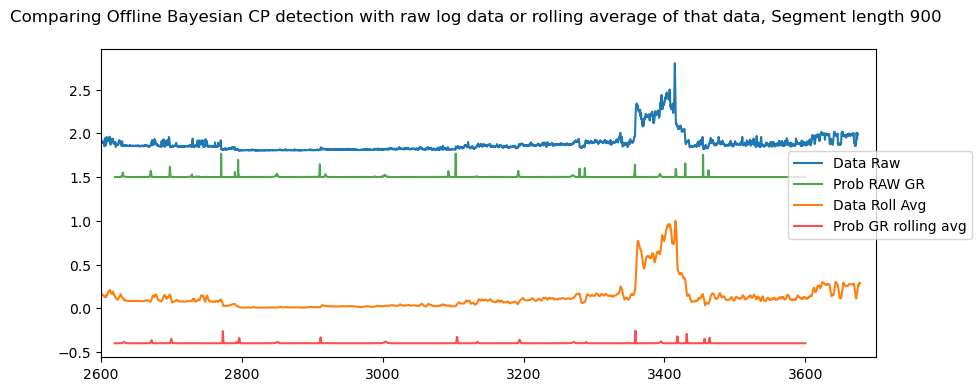

In [10]:
''' This Shows that performing the change point analysis on a log and a rolling average of the log produce comparable results, if not slightly muted for the Avg.'''
#data_f1A = wtool.compute_all_rolling_avg(df_f1A, window=30, periods=3)

_segment_length = 1400

data_f1A = df_add_CP_Prob(data_f1A, start=_logname_extent_min['f1A'], stop=_logname_extent_max['f1A'], log_dict=['GR', 'Roll_Avg_GR' ], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=_segment_length)

fig, ax = plt.subplots(1, figsize=(10,4))
ax.set_xlim((2600,3700))
#ax[0].plot(data_f1A['CP_Prob_Roll_Avg_GR']-data_f1A['CP_Prob_GR'])


ax.plot(data_f1A['GR']/data_f1A['GR'].max()+1.8, label='Data Raw')
ax.plot(data_f1A['CP_Prob_GR']+1.5, label='Prob RAW GR', color='green', alpha=0.7)

ax.plot(data_f1A['Roll_Avg_GR']/data_f1A['Roll_Avg_GR'].max(), label='Data Roll Avg')
ax.plot(data_f1A['CP_Prob_Roll_Avg_GR']-0.4, label='Prob GR rolling avg', alpha=0.7, color='red')

fig.suptitle('Comparing Offline Bayesian CP detection with raw log data or rolling average of that data, Segment length 900')
fig.legend(loc=('center right'));


##### Establishing changepoint TREND statistics for all input wells.
###### These will be used for geometric comparison with the stats. of change points of a compariTEE(unknown or investigated well) to compariTOR_s(known or prior wells). 

In [88]:
_log_ = 'GR'
_prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR']

_wellnames_ = ['f1','f1A', 'f1B', 'f11A', 'f11B'] #omitted F1C
_well_df_ = {'f1': df_f1clip, 'f1A': df_f1A, 'f1B': df_f1B,'f11A': df_f11A, 'f11B' : df_f11B} #omitted f1C

peak_height= 0.1 #Probability threshold to qualify as a distinct changepoint

for well in _wellnames_:
    for _log_choice, _prob_choice in zip(_log_list_nodt, _prob_list_nodt):

        globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

        print(well+ '_'+ _log_choice + ' complete')


#globals()[prefix + str(var_num) + suffix] =    

KeyError: 'CP_Prob_NPHI'

In [ ]:
#plt.plot(df_f1A['CP_Prob_GR'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy())


##### Finding breakpoints and trends for Volve input, ONLY UNIVARIATE LOGS for this example:
###### Changepoints are identified by SciPy find_peaks of a offline bayesian changepoint probability curve. Using sdt-python (implementation of Fearnhead 2006) 
###### Trend values are the mean for the data sections between breakpoints. (will soon include a more complete comparitor vector [CP, AvgL, AvgR, \sigma L, \sigma R, \alpha \beta \sigma L, \alpha \beta \sigma R])


##### This section runs a very permissible cosine similarity inference, so there is a lot of noise in the result.

Finding a more decerning algorithm is a topic of research on it's own but for this example it illustrates the point.
 

In [12]:
# Identified tops from the well 15-9 -F11A to compare against the output

f11A_FM = {0:'Norland GP FM', 1:'Ty FM', 2:'Ekofisk FM', 3:'Hod FM', 4:'Draupne FM', 5:'Heather FM', 6:'Heather FM (Sand)', 7:'Hugin FM', 8:'Sleipner FM'}
f11A_color = {0:'r', 1:'g', 2:'purple', 3:'orange', 4:'yellow', 5:'grey', 6:'black', 7:'pink', 8:'blue'}
f11A_tops = np.array([26000-26000, 26240-26000, 27945-26000, 31180-26000, 35258-26000, 35749-26000, 35852-26000, 35946-26000, 37020-26000])

vectors = []

In [26]:
# def prob_cpCorr(cpComparitee, cpComparitor, **kwargs):
    
#     '''Correlation engine for changepoint associations:
#     takes in two matrix (m  x n) of changepoints/trends. One compariTEE who is compared to the compariTOR.
    
#     Relative changepoint (vector[0]) and corresponding trend values (vector[1:]) 
    
    
#     Uses a kwarg to choose the geometric comparitor operation:
    
#     operator= 
#     'cosine'
#     'euclidean'
#     'theta'
#     'triangle'
#     'sector'
#     'mag'


#     Builds output of change points that correspond to all remaining changepoints after the matching input vector. 
#     '''

#     #for key, value in kwargs.items():
#         #print(f"{key}: {value}")

#     tee = cpComparitee
#     tor = cpComparitor
    
#     opFunc_dict = {'cosine':Cosine, 'euclidean': Euclidean, 'theta': Theta, 'triangle': Triangle, 'sector': Sector, 'magnitude': Magnitude_Difference} 
#     _operator = kwargs.get('operator')
    
#     _threshold = kwargs.get('thresh')

#     _df = kwargs.get('df')
#     _log = kwargs.get('log')



#     operator = opFunc_dict[_operator]

#     QumeProb = np.array(([0],[0]))
#     #k = 1
#     '''    
#     cos_thresh = 0.999999 # match is 1.0 (very tight threshhold, all reasonalble values are very close to 1.0)
#     euclidean_thresh = 0.1 # match is near zero
#     theta_thresh = 0.1745 # match is .1745
#     triangle_thresh = 0.2 # match is near zero
#     sector_thresh = 0.1 # match is near zero
#     '''
    
#     for i in range(1,len(tee)):
#         for j in range(1,len(tor)):
#             idx = int(tor[j][0])
#             teeTee = np.concatenate((tee[i-1][1:],tee[i][1:]))
#             torTor = np.concatenate((tor[j-1][1:],tor[j][1:]))
#             #print('iter')
#             #print(tor[j][1],tor[j][2])
#             #print(tee[i][1],tee[i][2])
#             #if tor[j][1] == tee[i][1] and tor[j][2] == tee[i][2]:
#             if operator(torTor, teeTee) >= _threshold:
#                 jump = int(tee[i][0])
#                 #print(type(jump)) 
#                 print('*MATCH at ' + _log + ' Tor depth '+ str(idx)+ ' to Tee depth '+str(jump)+ ' with ' + _operator + ' value ' + str(operator(torTor, teeTee)))
#                 probAdd = _df[_log][jump:].to_numpy()
#                 #print(tor[i][1],tor[i][2])
#                 #print(tee[j][1],tee[j][2])
#                 QumeProb = combine_vector_and_matrix(probAdd, QumeProb, jump)
#                 print('adding Tor probabilites from '+str(jump))     
#     #unique, counts = np.unique(CumulativeProb, return_counts=True)
    
#     V = QumeProb.sum(axis=0)
    
#     return V

In [89]:
def prob_cpCorr(cpComparitee, cpComparitor, **kwargs):
    
    '''Correlation engine for changepoint associations:
    takes in two matrix (m  x n) of changepoints/trends. One compariTEE who is compared to the compariTOR.
    
    Relative changepoint (vector[0]) and corresponding trend values (vector[1:]) 
    
    
    Uses a kwarg to choose the geometric comparitor operation:
    
    operator= 
    'cosine'
    'euclidean'
    'theta'
    'triangle'
    'sector'
    'mag'


    Builds output of change points that correspond to all remaining changepoints after the matching input vector. 
    '''

    #for key, value in kwargs.items():
        #print(f"{key}: {value}")

    tee = cpComparitee
    tor = cpComparitor
    
    opFunc_dict = {'cosine':Cosine, 'euclidean': Euclidean, 'theta': Theta, 'triangle': Triangle, 'sector': Sector, 'magnitude': Magnitude_Difference} 
    _operator = kwargs.get('operator')
    
    _threshold = kwargs.get('thresh')

    _df = kwargs.get('df')
    _log = kwargs.get('log')



    operator = opFunc_dict[_operator]

    QumeProb = np.array(([0],[0]))
    #k = 1
    '''    
    cos_thresh = 0.999999 # match is 1.0 (very tight threshhold, all reasonalble values are very close to 1.0)
    euclidean_thresh = 0.1 # match is near zero
    theta_thresh = 0.1745 # match is .1745
    triangle_thresh = 0.2 # match is near zero
    sector_thresh = 0.1 # match is near zero
    '''
    
    for i in range(1,len(tee)):
        for j in range(1,len(tor)):
            idx = int(tor[j][0])
            teeTee = np.concatenate((tee[i-1][1:],tee[i][1:]))
            torTor = np.concatenate((tor[j-1][1:],tor[j][1:]))
            #print('iter')
            #print(tor[j][1],tor[j][2])
            #print(tee[i][1],tee[i][2])
            #if tor[j][1] == tee[i][1] and tor[j][2] == tee[i][2]:
            if operator(torTor, teeTee) >= _threshold:
                jump = int(tee[i][0])
                #print(type(jump)) 
                print('*MATCH at ' + _log + ' Tor depth '+ str(idx)+ ' to Tee depth '+str(jump)+ ' with ' + _operator + ' value ' + str(operator(torTor, teeTee)))
                probAdd = _df[_log][jump:].to_numpy()
                #print(tor[i][1],tor[i][2])
                #print(tee[j][1],tee[j][2])
                QumeProb = combine_vector_and_matrix(probAdd, QumeProb, jump)
                print('adding Tor probabilites from '+str(jump))     
    #unique, counts = np.unique(CumulativeProb, return_counts=True)
    
    V = QumeProb.sum(axis=0)
    
    return V# , QumeProb

In [90]:
# _log_ = 'GR'
# _prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR']

_wellnames_ = ['f1','f1A', 'f1B', 'f11B']
_well_df_ = {'f1': df_f1clip, 'f1A': df_f1A, 'f1B': df_f1B, 'f11A': df_f11A, 'f11B' : df_f11B} # omitted f1C

#peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

operator = 'cosine'
thresh = {'CP_Prob_NPHI': 0.99999 ,'CP_Prob_RHOB': 0.99999992,'CP_Prob_GR': 0.99996}#0.9999


comparitee = 'f11A'

Tor = []

for well in _wellnames_:
    for _prob_, _log_ in zip(_prob_list_nodt,_log_list_nodt):
        print(_prob_,_log_)
        Tee = globals()[comparitee+'_'+_log_+'_CPstats'] 
        Tor = globals()[well+'_'+_log_+'_CPstats']
    
        globals()[well+'_'+comparitee+'_'+_log_+'_prob'] = cp_Comp.prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh[_prob_], df=_well_df_[well], log=_prob_)

    #f1_11A_GR_prob = prob_cpCorr(f11A_GRmu, f1_GRmu, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')

CP_Prob_NPHI NPHI
*MATCH at CP_Prob_NPHI Tor depth 5491 to Tee depth 1993 with cosine value 0.9999925227884694


KeyError: 'CP_Prob_NPHI'

In [ ]:
np.shape(f1_f11A_RHOB_prob)

(8724,)

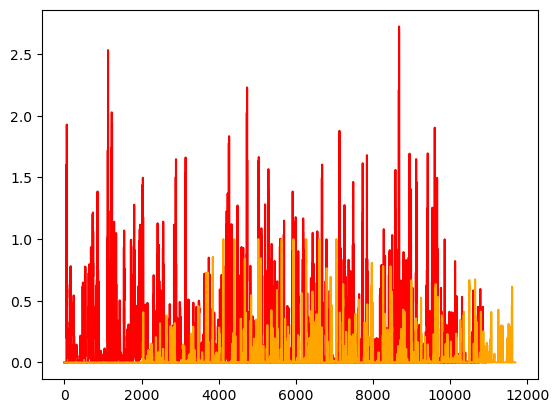

In [74]:
plt.plot(f1_f11A_RHOB_prob, color='g')
plt.plot(f1_f11A_GR_prob, color='r')
plt.plot(f1_f11A_NPHI_prob, color='orange')

In [75]:
''' Derived probability curves from the comparitors statistics are now combined, with simple matrix stacking, into a
total probability curve as wells as curves that are composed of the individual log components '''

# f11A_probmatrix = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob, f1A_f11A_NPHI_prob,  f11B_f11A_NPHI_prob, f1B_f11A_NPHI_prob,
#                                                      f1_f11A_RHOB_prob, f1A_f11A_RHOB_prob,  f11B_f11A_RHOB_prob, f1B_f11A_RHOB_prob,
#                                                      f1_f11A_GR_prob, f1A_f11A_GR_prob, f11B_f11A_GR_prob, f1B_f11A_GR_prob, 
#                                                     #f1_f11A_PEF_prob, f1A_f11A_PEF_prob, f11B_f11A_PEF_prob, f1B_f11A_PEF_prob,
#                                                     )

f11A_probmatrixNPHI = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob,
                                                        f1A_f11A_NPHI_prob,
                                                         f1B_f11A_NPHI_prob,
                                                         #f1C_f11A_NPHI_prob, 
                                                         f11B_f11A_NPHI_prob)

f11A_probmatrixRHOB = cp_Comp.combine_vectors_to_matrix_(f1_f11A_RHOB_prob,
                                                         f1A_f11A_RHOB_prob, 
                                                         f1B_f11A_RHOB_prob,
                                                         #f1C_f11A_RHOB_prob, 
                                                         f11B_f11A_RHOB_prob)

f11A_probmatrixGR = cp_Comp.combine_vectors_to_matrix_(f1_f11A_GR_prob,
                                                       f1A_f11A_GR_prob,
                                                       f1B_f11A_GR_prob, 
                                                       #f1C_f11A_GR_prob, 
                                                       f11B_f11A_GR_prob
                                                       )


f11A_probmatrix = cp_Comp.combine_vectors_to_matrix_(np.sum(f11A_probmatrixGR, axis=1),
                                                     np.sum(f11A_probmatrixNPHI, axis=1),
                                                     np.sum(f11A_probmatrixRHOB, axis=1)
                                                    )   

# f11A_probmatrixPEF = cp_Comp.combine_vectors_to_matrix_(f1_f11A_PEF_prob, # PEF produces no results :(
#                                                          f1A_f11A_PEF_prob, 
#                                                          f1C_f11A_PEF_prob, 
#                                                          f11B_f11A_PEF_prob) #f1B_11A_PEFcorr,

f11A_all_prob = cp_Comp.combine_vectors_to_matrix_(df_f11A['CP_Prob_GR'],
                                                    df_f11A['CP_Prob_NPHI'],
                                                    #df_f11A['CP_Prob_PEF'],
                                                    df_f11A['CP_Prob_RHOB']
                                                    )




rows  14374 columns 4
rows  10707 columns 4
rows  14506 columns 4
rows  14506 columns 3
rows  11000 columns 3


In [68]:
# this the clipped Gamma Ray log from the Comparitee vector

# f11A_gr = (cp_Comp.normalize_array(df_f11Aclip['GR'].to_numpy(), 0, 0))+26000
# f11A_nphi = (cp_Comp.normalize_array(df_f11Aclip['NPHI'].to_numpy(), 0, 0))+26000
# #f11A_pef = cp_Comp.normalize_array(df_f11A['PEF'][2600:].to_numpy(), 0, 0)
# f11A_rhob = (cp_Comp.normalize_array(df_f11Aclip['RHOB'].to_numpy(), 0, 0))+26000

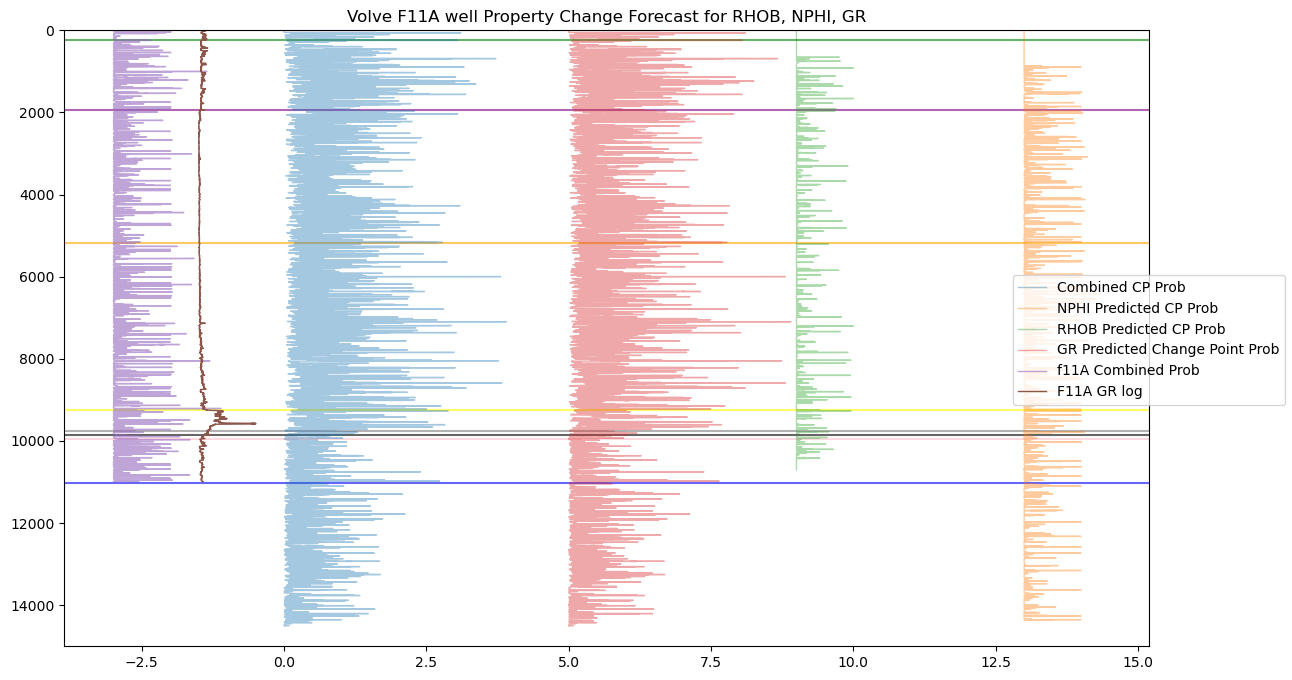

In [76]:
import matplotlib as mpl
#cmap = mpl.colormaps['']
fig, ax = plt.subplots(1, figsize=(14,8))
#plt.figure(figsize=(10,15))
ax.set_ylim((15000,0))
#ax.set_xlim(25)
f11A_top10 = f11A_tops #25400
k=0
for i in f11A_top10:
    ax.axhline(i, alpha=0.6, color=f11A_color[k])#, label=f11A_FM[k])
    #print(k)
    k=k+1
ax.plot(np.sum(f11A_probmatrix, axis=1), np.arange(len(f11A_probmatrix)), linewidth=1, alpha=.4, label='Combined CP Prob' )
ax.plot(np.sum(f11A_probmatrixNPHI, axis=1)+13, np.arange(len(f11A_probmatrixNPHI)), linewidth=1, alpha=.4, label = 'NPHI Predicted CP Prob' )
ax.plot(np.sum(f11A_probmatrixRHOB, axis=1)+9, np.arange(len(f11A_probmatrixRHOB)), linewidth=1, alpha=.4, label = 'RHOB Predicted CP Prob' )
#ax.plot(np.sum(f11A_probmatrixPEF, axis=1)+7.6, np.arange(len(f11A_probmatrixPEF)), linewidth=1, alpha=.6, label='PEF Predicted CP Prob')
ax.plot(np.sum(f11A_probmatrixGR, axis=1)+5, np.arange(len(f11A_probmatrixGR)), linewidth=1, alpha=.4, label = 'GR Predicted Change Point Prob' )
#ax.plot(f11A_gr*3, np.arange(len(f11A_gr)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_pef*3+ +7, np.arange(len(f11A_pef)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_nphi*3, np.arange(len(f11A_nphi)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_rhob*3, np.arange(len(f11A_rhob)) , linewidth=1, alpha=.6, label='GR f11A')
ax.plot(np.sum(f11A_all_prob, axis=1)-3, np.arange(len(f11A_all_prob)), linewidth=1, alpha=0.6, label='f11A Combined Prob')
f11A_GR = (cp_Comp.normalize_array(wtool.replace_nans(df_f11A['GR'].to_numpy(), method='global_average'), 0.1 ,0.1))
f11A_y = np.arange(len(f11A_GR))
ax.plot(f11A_GR-1.5, f11A_y, linewidth=1, label='F11A GR log')
maxx = len(df_f11A)

plt.title('Volve F11A well Property Change Forecast for RHOB, NPHI, GR')
#f11A_top10
#cmap = plt.colormaps('turbo')


fig.legend(loc='center right')

##### So, there are some issues with this result... mostly that they are ambiguous.

###### first and most obvious are that none of the formation tops (horizontal lines) have any obvious relation to the probaility mass of ony of the curves, frankly there is also a lot of noise. In the signal. 

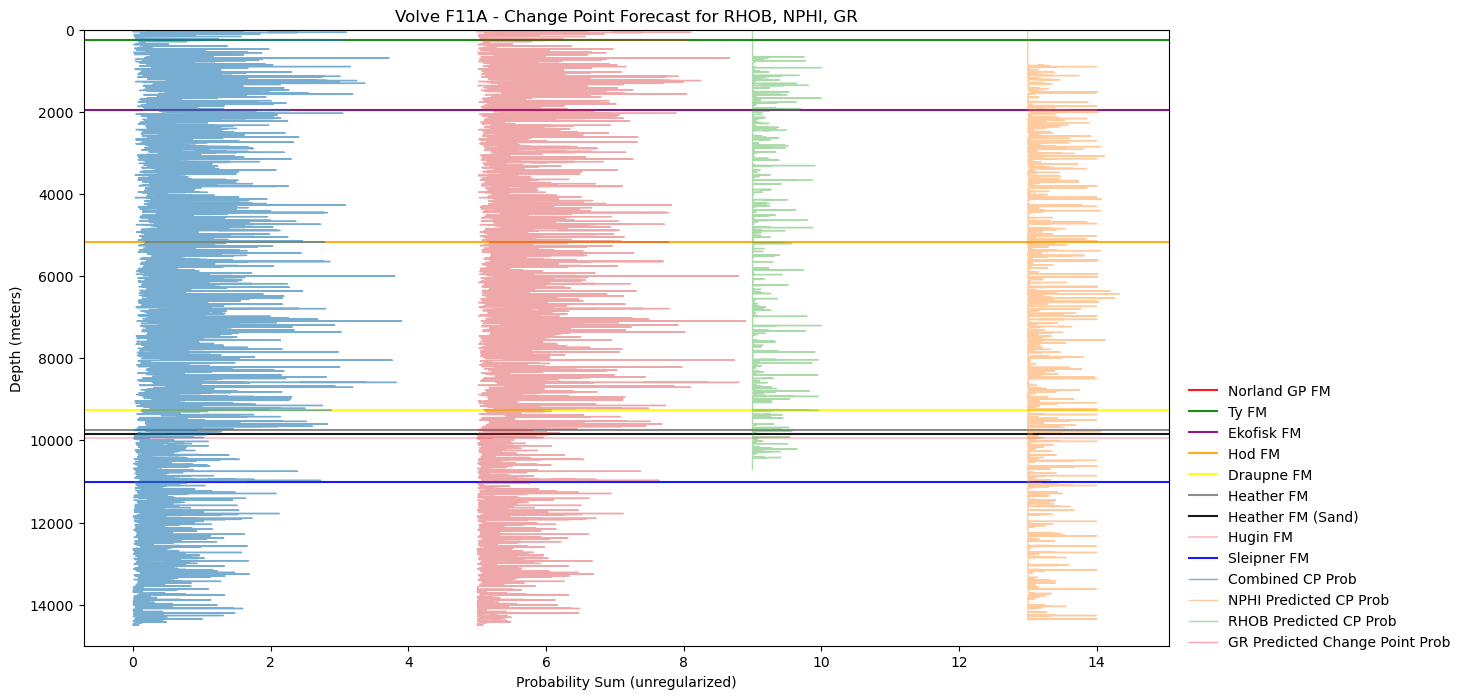

In [79]:

#cmap = mpl.colormaps['']
fig, ax = plt.subplots(1, figsize=(14,8))
#plt.figure(figsize=(10,15))
ax.set_ylim((15000,0))
#ax.set_xlim(25)
f11A_top10 = f11A_tops #25400
k=0
for i in f11A_top10:
    ax.axhline(i, alpha=0.9, color=f11A_color[k], label=f11A_FM[k], linewidth=1.5)
    #print(k)
    k=k+1
ax.plot(np.sum(f11A_probmatrix, axis=1), np.arange(len(f11A_probmatrix)), linewidth=1, alpha=.6, label='Combined CP Prob' )
ax.plot(np.sum(f11A_probmatrixNPHI, axis=1)+13, np.arange(len(f11A_probmatrixNPHI)), linewidth=1, alpha=.4, label = 'NPHI Predicted CP Prob' )
ax.plot(np.sum(f11A_probmatrixRHOB, axis=1)+9, np.arange(len(f11A_probmatrixRHOB)), linewidth=1, alpha=.4, label = 'RHOB Predicted CP Prob' )
#ax.plot(np.sum(f11A_probmatrixPEF, axis=1)+7.6, np.arange(len(f11A_probmatrixPEF)), linewidth=1, alpha=.6, label='PEF Predicted CP Prob')
ax.plot(np.sum(f11A_probmatrixGR, axis=1)+5, np.arange(len(f11A_probmatrixGR)), linewidth=1, alpha=.4, label = 'GR Predicted Change Point Prob' )
#ax.plot(f11A_gr*3, np.arange(len(f11A_gr)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_pef*3+ +7, np.arange(len(f11A_pef)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_nphi*3, np.arange(len(f11A_nphi)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_rhob*3, np.arange(len(f11A_rhob)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(np.sum(f11A_all_prob, axis=1)-3, np.arange(len(f11A_all_prob)), linewidth=1, alpha=0.7, label='f11A Combined Prob')
#f11A_GR = (cp_Comp.normalize_array(wtool.replace_nans(df_f11A['GR'].to_numpy(), method='global_average'), 0.1 ,0.1))
#f11A_y = np.arange(len(f11A_GR))
#ax.plot(f11A_GR-1.5, f11A_y, linewidth=1, label='F11A GR log')
#maxx = len(df_f11A)

plt.title('Volve F11A - Change Point Forecast for RHOB, NPHI, GR')
#f11A_top10
#cmap = plt.colormaps('turbo')
ax.set_xlabel('Probability Sum (unregularized)')
ax.set_ylabel('Depth (meters)')

fig.legend(loc='center right', frameon=False, bbox_to_anchor=(.11, 0.22, 1., .102),)
fig.savefig('Small100dp_changepoint_high_thresh.svg')

In [91]:
import gempy as gp
import numpy as np

class well_from_graben_model(object):
    
    ''' This class has only one job and this is to toss out synthetic well logs for a gempy graben model (Lisa's)
    Density (RHO) and Porosity (PHI) are populated based on the lithology codes from the vertical borings
    
    Pro Tip!
    The compute_model function will bork without any additional values populated in the surface values, for reasons 
    that I am not sure of... some additonal features are built in the model, like sections and this was due to 
    previous attempts at creating well logs from 2D sections, which are still being worked with.
    
    Parameters:
        x : map section x position of sample (boring)
        y : map section y position of sample (boring)
        z_top : This is the top of the boring (nearer to the surface)
        z_bottom : This is the bottom of the boring (near the 'basement')
        res : Resolution of the log (number of equidistant samples)
        Rnoise : RHO (density) noise sigma (stdDev) for the convolution step (random normal, using the true value as mu)
        Pnoise : PHI (porosity) noise sigma
    '''
    
    def __init__(self, x, y, z_top, z_bottom, res, Rnoise, Pnoise):
        
        self.x = x
        self.y = y
        self.z_top = z_top
        self.z_bottom = z_bottom
        self.res = res
        self.Rnoise = Rnoise
        self.Pnoise = Pnoise
        #self.return_well = self.return_well(self.wellpath, self.welldata)
        #self.phi_rho = self.phi_rho
        #self.build_1d_well_path = self.build_1d_well_path
        
        data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'

        geo_model = gp.create_data('viz_3d',
                           [0, 2000, 0, 2000, 0, 1600],
                           [50, 50, 50],
                           path_o=data_path + "data/input_data/lisa_models/foliations" + str(
                               7) + ".csv",
                           path_i=data_path + "data/input_data/lisa_models/interfaces" + str(
                               7) + ".csv"
                                )

        gp.map_stack_to_surfaces(geo_model,
                                {"Fault_1": 'Fault_1', "Fault_2": 'Fault_2',
                                 "Strat_Series": ('Sandstone', 'Siltstone', 'Shale', 'Sandstone_2', 'Schist', 'Gneiss')}
                                )
        geo_model.add_surface_values([[0,0,.2, .3, .4, .2, .1, 0.03, .0], [0,0,2.1, 2, 1.8, 2.1, 2.4, 2.5, 2.9]], ['porosity', 'bulk_density'])
        geo_model.set_is_fault(['Fault_1', 'Fault_2'])
        section_dict = {'well1': ([100, 500], [100, 1100], [20, 20]), 'well2': ([10,2000],[2000,10],[100,100])
                }
        geo_model.set_section_grid(section_dict)
        #gp.plot.plot_section_traces(geo_model)
        geo_model.get_active_grids()
        #gp.set_interpolator(geo_model, theano_optimizer='fast_compile')
        #geo_model.get_active_grids()
        self.well_path = self.build_1d_well_path(x, y, z_top, z_bottom, res)
        print(self.well_path[:4])
        geo_model.get_active_grids()
        
        gp.set_interpolator(geo_model, theano_optimizer='fast_compile')
        
        sol = gp.compute_model(geo_model, at=self.well_path)
        self.well_data = self.phi_rho(sol, self.Rnoise, self.Pnoise)
        print(self.well_data[:1])
        #self.return_well(self.well_path, self.well_data)
        
        #return self.well_path, self.well_data
    #if __name__ == '__main__':
    
    def build_1d_well_path(self, x, y, z_top, z_bottom, res): #z_bottom and z_top are relative to a lower model boundary (basement) zero point, which puts the surface closer to zero 
        x = np.ones(res)*x
        y = np.ones(res)*y
        z = np.linspace(z_bottom , z_top, res)
        #well_path1 = np.empty(3)

        for i in range(res):
            if i == 0:
                well_path= np.array((x[0],y[0],z[0]))
            else:
                well_path = np.vstack((well_path, np.array((x[i],y[i],z[i]))), dtype=object)
        return well_path

    def phi_rho(self, sol, Rnoise, Pnoise):
        phi = []
        rho = []
        phiRho = np.vstack(([0,0,0,.2, .3, .4, .2, .1, 0.03, .0], [0,0,0,2.1, 2, 1.8, 2.1, 2.4, 2.5, 2.9]))
        #phiRho[1,4]
        for i in sol.custom[0][0]: 
            i = int(i)
            phi.append(phiRho[0,i])
            rho.append(phiRho[1,i])
        phiNoise = np.random.normal(phi, Pnoise)
        rhoNoise = np.random.normal(rho, Rnoise)
        return phi, phiNoise, rho, rhoNoise
    
    def return_well(self):
        return self.well_path, self.well_data
    
        
        
        
    

No module named 'osgeo'


In [92]:
#import synthetic_graben_model as grab
# data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'

# geo_model = gp.create_data('viz_3d',
#                            [0, 2000, 0, 2000, 0, 1600],
#                            [50, 50, 50],
#                            path_o=data_path + "data/input_data/lisa_models/foliations" + str(
#                                7) + ".csv",
#                            path_i=data_path + "data/input_data/lisa_models/interfaces" + str(
#                                7) + ".csv"
#                            )

wellpath1, welldata1 = well_from_graben_model(10, 10, 1600, 0, 1600, .08, .04).return_well() #( x, y, z_top, z_bottom, res, Rnoise, Pnoise)
wellpath2, welldata2 = well_from_graben_model(1900, 1900, 1600, 0, 1600, .08, .04).return_well()
wellpath3, welldata3 = well_from_graben_model(1000, 1000, 1600, 0, 1600, .08, .04).return_well()
wellpath4, welldata4 = well_from_graben_model(600, 1700, 1600, 0, 1600, .08, .04).return_well()

randx = np.random.randint(0,2000)
randy = np.random.randint(0,2000)
randz = np.random.randint(0,1600)

randI = np.random.randint
randIz1 = randI(0,1600)
randIz2 = randI(0,1600)

wellpathRand1, welldataRand1 = well_from_graben_model(randI(0,2000), randI(0,2000), randIz1, 0, randIz1, .08, .03).return_well()
wellpathRand2, welldataRand2 = well_from_graben_model(randI(0,2000), randI(0,2000), randIz2, 0, randIz2 , .08, .03).return_well()

Active grids: ['regular']


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[10.0 10.0 0.0]
 [10.0 10.0 1.0006253908692933]
 [10.0 10.0 2.0012507817385865]
 [10.0 10.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[1900.0 1900.0 0.0]
 [1900.0 1900.0 1.0006253908692933]
 [1900.0 1900.0 2.0012507817385865]
 [1900.0 1900.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[1000.0 1000.0 0.0]
 [1000.0 1000.0 1.0006253908692933]
 [1000.0 1000.0 2.0012507817385865]
 [1000.0 1000.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[600.0 1700.0 0.0]
 [600.0 1700.0 1.0006253908692933]
 [600.0 1700.0 2.0012507817385865]
 [600.0 1700.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[1374.0 771.0 0.0]
 [1374.0 771.0 1.000677966101695]
 [1374.0 771.0 2.00135593220339]
 [1374.0 771.0 3.0020338983050845]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[219.0 949.0 0.0]
 [219.0 949.0 1.002053388090349]
 [219.0 949.0 2.004106776180698]
 [219.0 949.0 3.006160164271047]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

C:\Users\ada55080\AppData\Local\Temp\ipykernel_15752\1101151736.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()#.plot()


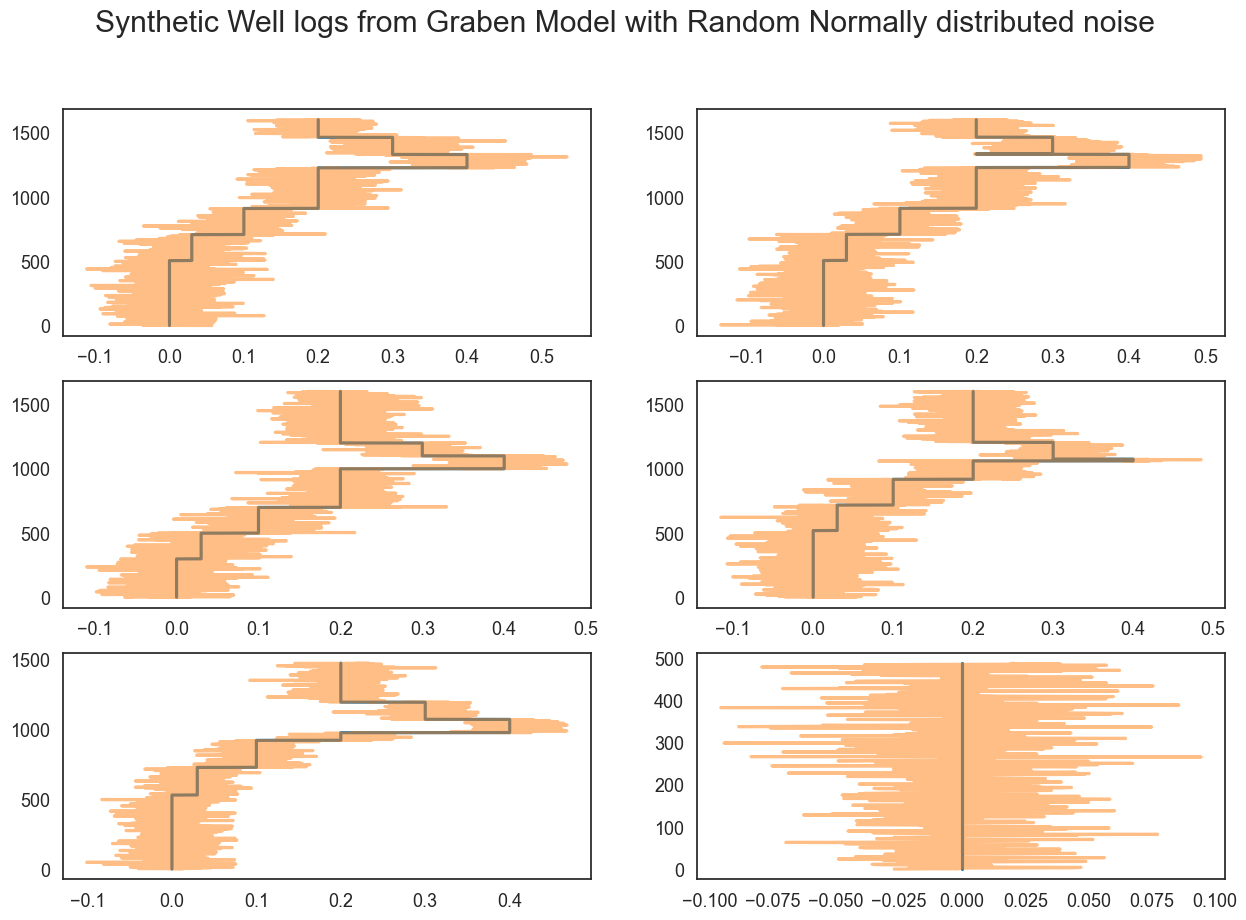

In [96]:
import matplotlib.pyplot as plt
#welldata1[0]
#wellpath1[:,2]
fig, ax = plt.subplots(3,2, figsize=(15,10))
ax[0,0].plot(welldata1[0], wellpath1[:,2])
ax[0,0].plot(welldata1[1], wellpath1[:,2], alpha=0.5)

ax[0,1].plot(welldata2[0], wellpath2[:,2])
ax[0,1].plot(welldata2[1], wellpath2[:,2], alpha=0.5)

ax[1,0].plot(welldata3[0], wellpath3[:,2])
ax[1,0].plot(welldata3[1], wellpath3[:,2], alpha=0.5)

ax[1,1].plot(welldata4[0], wellpath4[:,2])
ax[1,1].plot(welldata4[1], wellpath4[:,2], alpha=0.5)

ax[2,0].plot(welldataRand1[0], wellpathRand1[:,2])
ax[2,0].plot(welldataRand1[1], wellpathRand1[:,2], alpha=0.5)

ax[2,1].plot(welldataRand2[0], wellpathRand2[:,2])
ax[2,1].plot(welldataRand2[1], wellpathRand2[:,2], alpha=0.5)

fig.suptitle('Synthetic Well logs from Graben Model with Random Normally distributed noise')
fig.show()#.plot()

In [97]:
df_grab_1 = pd.DataFrame()
well1 = pd.DataFrame(np.array([wellpath1[:,0], wellpath1[:,1], wellpath1[:,2], welldata1[1], welldata1[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well2 = pd.DataFrame(np.array([wellpath2[:,0], wellpath2[:,1], wellpath2[:,2], welldata2[1], welldata2[3]],dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well3 = pd.DataFrame(np.array([wellpath3[:,0], wellpath3[:,1], wellpath3[:,2], welldata3[1], welldata3[3]],dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well4 = pd.DataFrame(np.array([wellpath4[:,0], wellpath4[:,1], wellpath4[:,2], welldata4[1], welldata4[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well5 = pd.DataFrame(np.array([wellpathRand1[:,0], wellpathRand1[:,1], wellpathRand1[:,2], welldataRand1[1], welldataRand1[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well6 = pd.DataFrame(np.array([wellpathRand2[:,0], wellpathRand2[:,1], wellpathRand2[:,2], welldataRand2[1], welldataRand2[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])


In [98]:
import sdt

_syn_grab_log = ['PHI', 'RHO']


_segment_length = 800 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency
_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals
_method = 'full_cov'
_prior = 'const'
_engine = 'numba'
_normalize = True


#well1phi = np.array(((well1['PHI'].values)**2)**0.5, dtype='float64')
#type(well1phi) 
#well1_prob_phiba = cp_Tools.bayes_offline_sdt(well1phi, engine='numba')# method=_method, prior=_prior, engine=_engine)#, normal=_normalize)

##well1 = 
df_add_CP_Prob(well1, start=0, stop=len(well1), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

#well2 = 
df_add_CP_Prob(well2, start=0, stop=len(well2), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

#well3 = 
df_add_CP_Prob(well3, start=0, stop=len(well3), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

#well4 = 
df_add_CP_Prob(well4, start=0, stop=len(well4), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

#well5 = 
df_add_CP_Prob(well5, start=0, stop=len(well5), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

#well6 = 
df_add_CP_Prob(well6, start=0, stop=len(well6), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)


         X     Y               MD           PHI           RHO
0     10.0  10.0     0.0000000000  0.0569535408  2.9958923034
1     10.0  10.0     1.0006253909 -0.0132828660  2.9058865325
2     10.0  10.0     2.0012507817 -0.0084889825  2.9046312662
3     10.0  10.0     3.0018761726  0.0097316102  2.9328777814
4     10.0  10.0     4.0025015635 -0.0362975490  2.9229381974
...    ...   ...              ...           ...           ...
1595  10.0  10.0  1595.9974984365  0.1437770032  2.0072978276
1596  10.0  10.0  1596.9981238274  0.2460560378  1.9602412640
1597  10.0  10.0  1597.9987492183  0.2565151677  2.0717151041
1598  10.0  10.0  1598.9993746091  0.1832314493  2.1446275457
1599  10.0  10.0  1600.0000000000  0.2481875269  2.1448412171

[1600 rows x 5 columns]
 finding changepoints in PHI
method- full_cov, prior- const, engine- numba
Segmenting into 800
/n finding changepoints in RHO1600 of 1600
method- full_cov, prior- const, engine- numba
Segmenting into 800
/n           X       Y     

,X,Y,MD,PHI,RHO,CP_Prob_PHI,CP_Prob_RHO
0,219.0,949.0,0.0000000000,-0.0269700936,2.9222861523,0.0000000000,0.0000000000
1,219.0,949.0,1.0020533881,-0.0011632142,2.8973388789,0.0175164273,0.0000013492
2,219.0,949.0,2.0041067762,-0.0213077257,2.8802148850,0.0106042335,0.0000023085
3,219.0,949.0,3.0061601643,0.0441313695,2.8037341014,0.0033599029,0.0000070749
4,219.0,949.0,4.0082135524,0.0471269659,2.8779145626,0.0031275207,0.0000068988
...,...,...,...,...,...,...,...
483,219.0,949.0,483.9917864476,-0.0388348256,2.8610618336,0.0090769384,0.0005599541
484,219.0,949.0,484.9938398357,-0.0190355540,2.9394488225,0.0195302977,0.0003222826
485,219.0,949.0,485.9958932238,0.0389462397,2.9088712918,0.0065286030,0.0004308148
486,219.0,949.0,486.9979466119,0.0191742150,2.9277193087,0.0030854381,0.0003921583


<Axes: >

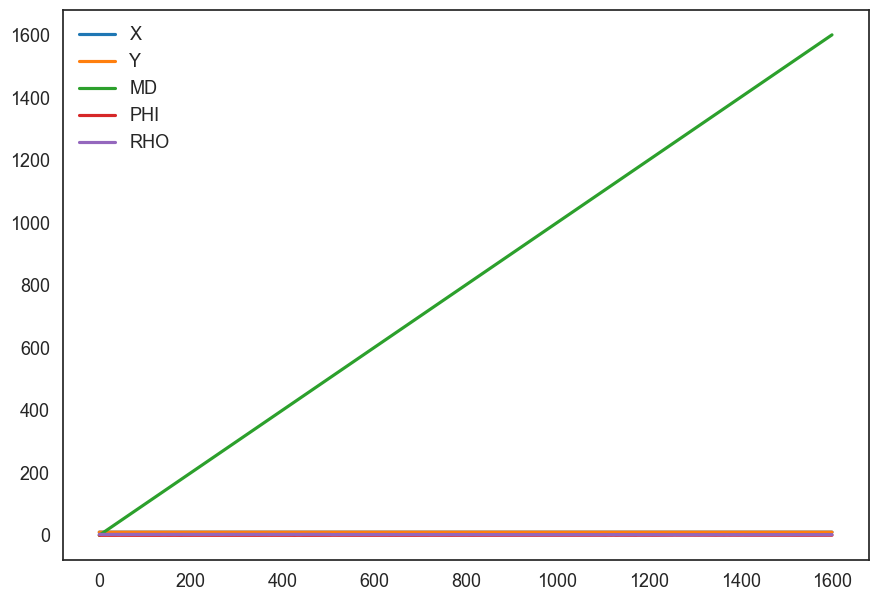

In [101]:
#Looking at the data and the CP solution
#well1[['RHO', 'CP_Prob_RHO']].plot()
well1.plot()


In [102]:
''' Now that the compriTORs are build from the synthetic model we drill a well in a random spot on the model
and see how this CompariTEE can have property changes predited by what we know from the wells before'''


#Drilling random observation well within the 

np.random.seed(seed=1234) # static when this needs repeating

TEEdepth = 1400 #This sets the depth of the comparitee well **** must change the depth in _logname_extents_max_ dict in the folloeing cell to match***


'''This runs a synthetic well from the well drilling class above:

in an investigation, the CompariTEE well location could also be 'drilled' in the best known model to be used as an input for 
a CompariTOR, as this model will include some value based on expert interpretations and a realistic interpolation of current
 observations'''
xx =  randI(0,2000)
yy =  randI(0,2000)
print(xx,yy)

OBSERwellpath, OBSERwelldata = well_from_graben_model(xx, yy, TEEdepth, 0, TEEdepth , .08, .03).return_well()

well7 = pd.DataFrame(np.array([OBSERwellpath[:,0], OBSERwellpath[:,1], OBSERwellpath[:,2], OBSERwelldata[1], OBSERwelldata[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])

well7 = df_add_CP_Prob(well7, start=0, stop=len(well7), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)


815 723
Active grids: ['regular']


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[815.0 723.0 0.0]
 [815.0 723.0 1.0007147962830594]
 [815.0 723.0 2.0014295925661187]
 [815.0 723.0 3.002144388849178]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [95]:
#Checking the depths of the wells
len(well1), len(well2), len(well3), len(well4),len(well5), len(well6), len(well7)

NameError: name 'well7' is not defined

In [43]:
'''This build the trends '''

# _log_ = 'GR'
# _prob_ = 'CP_Prob_GR'

_log_list_ = ['RHO','PHI']
_prob_list_ = ['CP_Prob_PHI','CP_Prob_RHO']

_wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6', 'well7']
_well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6, 'well7': well7}

_logname_extent_min = {'well1': 0 ,'well2' : 0, 'well3' : 0 , 'well4': 0 , 'well5' : 0 , 'well6': 0, 'well7' :0 }
_logname_extent_max = {'well1': 1600 ,'well2' : 1600, 'well3' : 1600 , 'well4': 1600 , 'well5' : 1075 , 'well6': 1497, 'well7' : len(well7) }

peak_height= 0.07 #Probability threshold to qualify as a distinct changepoint

for well in _wellnames_:
    for _log_choice, _prob_choice in zip(_log_list_, _prob_list_):

        globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

        print(well+ '_'+ _log_choice + ' complete')



4 Change points: [ 907  909 1224 1462]
well1_RHO complete
3 Change points: [ 505 1226 1328]
well1_PHI complete
6 Change points: [ 905  907  910  912 1227 1461]
well2_RHO complete
7 Change points: [ 506  709  711  714  912 1228 1329]
well2_PHI complete
5 Change points: [ 493  498  998 1199 1201]
well3_RHO complete
6 Change points: [ 299  700  702  999 1095 1097]
well3_PHI complete
3 Change points: [ 716  916 1059]
well4_RHO complete
3 Change points: [519 917 921]
well4_PHI complete
0 Change points: []
well5_RHO complete
0 Change points: []
well5_PHI complete
0 Change points: []
well6_RHO complete
0 Change points: []
well6_PHI complete
3 Change points: [ 483  987 1199]
well7_RHO complete
5 Change points: [ 289  687  988 1076 1079]
well7_PHI complete


In [44]:
# _log_ = 'GR'
# _prob_ = 'CP_Prob_GR'

_log_list_ = ['RHO','PHI']
_prob_list_ = ['CP_Prob_PHI','CP_Prob_RHO']

_wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6', 'well7']
_well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6, 'well7': well7}

#peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

operator = 'cosine'
thresh = 0.997


comparitee = 'well7'

Tor = []

for well in _wellnames_:
    for _prob_, _log_ in zip(_prob_list_,_log_list_):
        print(_prob_,_log_)
        Tee = globals()[comparitee+'_'+_log_+'_CPstats'] 
        Tor = globals()[well+'_'+_log_+'_CPstats']
    
        globals()[well+'_'+comparitee+'_'+_log_+'_prob'] = cp_Comp.prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh, df=_well_df_[well], log=_prob_)
        
    #f1_11A_GR_prob = prob_cpCorr(f11A_GRmu, f1_GRmu, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')

CP_Prob_PHI RHO
*MATCH at CP_Prob_PHI Tor depth 907 to Tee depth 483 with cosine value 0.9988372086913428
adding Tor probabilites from 483
*MATCH at CP_Prob_PHI Tor depth 907 to Tee depth 987 with cosine value 0.9991642543969916
adding Tor probabilites from 987
*MATCH at CP_Prob_PHI Tor depth 1224 to Tee depth 987 with cosine value 0.9976850242614146
adding Tor probabilites from 987
*MATCH at CP_Prob_PHI Tor depth 1462 to Tee depth 1199 with cosine value 0.9999920018567581
adding Tor probabilites from 1199
CP_Prob_RHO PHI
*MATCH at CP_Prob_RHO Tor depth 1226 to Tee depth 687 with cosine value 0.9986648609608009
adding Tor probabilites from 687
*MATCH at CP_Prob_RHO Tor depth 1328 to Tee depth 1079 with cosine value 0.9994369753410122
adding Tor probabilites from 1079
CP_Prob_PHI RHO
*MATCH at CP_Prob_PHI Tor depth 905 to Tee depth 483 with cosine value 0.9987697992925918
adding Tor probabilites from 483
*MATCH at CP_Prob_PHI Tor depth 905 to Tee depth 987 with cosine value 0.9982502463

<Axes: >

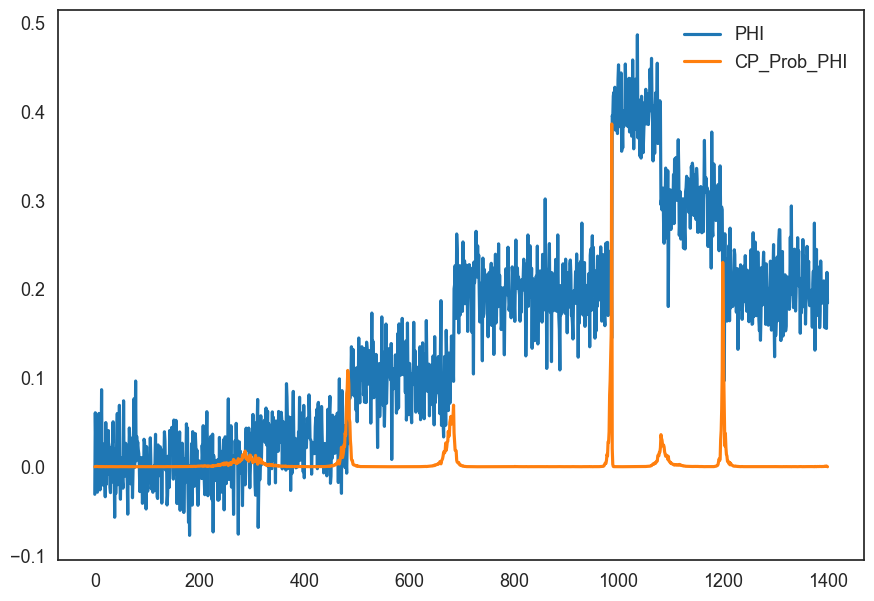

In [45]:
well7[['PHI', 'CP_Prob_PHI']].plot()

In [46]:
well7_probmatrix = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob,
                                                         well2_well7_RHO_prob,
                                                         well3_well7_RHO_prob, 
                                                         well4_well7_RHO_prob,
                                                         well5_well7_RHO_prob, 
                                                         well6_well7_RHO_prob,
                                                         well1_well7_PHI_prob,
                                                         well2_well7_PHI_prob,
                                                         well3_well7_PHI_prob, 
                                                         well4_well7_PHI_prob,
                                                         well5_well7_PHI_prob, 
                                                         well6_well7_PHI_prob)


well7_probmatrixPHI = cp_Comp.combine_vectors_to_matrix_(well1_well7_PHI_prob,
                                                         well2_well7_PHI_prob,
                                                         well3_well7_PHI_prob, 
                                                         well4_well7_PHI_prob,
                                                         well5_well7_PHI_prob, 
                                                         well6_well7_PHI_prob)


well7_probmatrixRHO = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob,
                                                         well2_well7_RHO_prob,
                                                         well3_well7_RHO_prob, 
                                                         well4_well7_RHO_prob,
                                                         well5_well7_RHO_prob, 
                                                         well6_well7_RHO_prob)

well7_all_prob = cp_Comp.combine_vectors_to_matrix_(well7['CP_Prob_PHI'].values, well7['CP_Prob_RHO'].values)

peaks = cp_Tools.find_prob_peaks(np.sum(well7_all_prob, axis=1), height=0.1)

rows  1600 columns 12
rows  1600 columns 6
rows  1600 columns 6
rows  1400 columns 2


In [47]:
#peaks
true_peaks = [288, 483, 687, 987, 1077, 1199]

300
300
4 Change points: [ 907  909 1224 1462]
well1_RHO complete
3 Change points: [ 505 1226 1328]
well1_PHI complete
6 Change points: [ 905  907  910  912 1227 1461]
well2_RHO complete
7 Change points: [ 506  709  711  714  912 1228 1329]
well2_PHI complete
5 Change points: [ 493  498  998 1199 1201]
well3_RHO complete
6 Change points: [ 299  700  702  999 1095 1097]
well3_PHI complete
3 Change points: [ 716  916 1059]
well4_RHO complete
3 Change points: [519 917 921]
well4_PHI complete
0 Change points: []
well5_RHO complete
0 Change points: []
well5_PHI complete
0 Change points: []
well6_RHO complete
0 Change points: []
well6_PHI complete
0 Change points: []
well7_RHO complete
1 Change points: [289]
well7_PHI complete
300
CP_Prob_PHI RHO
CP_Prob_RHO PHI
CP_Prob_PHI RHO
CP_Prob_RHO PHI
CP_Prob_PHI RHO
CP_Prob_RHO PHI
CP_Prob_PHI RHO
CP_Prob_RHO PHI
CP_Prob_PHI RHO
CP_Prob_RHO PHI
CP_Prob_PHI RHO
CP_Prob_RHO PHI
CP_Prob_PHI RHO
CP_Prob_RHO PHI
*MATCH at CP_Prob_RHO Tor depth 289 to Te

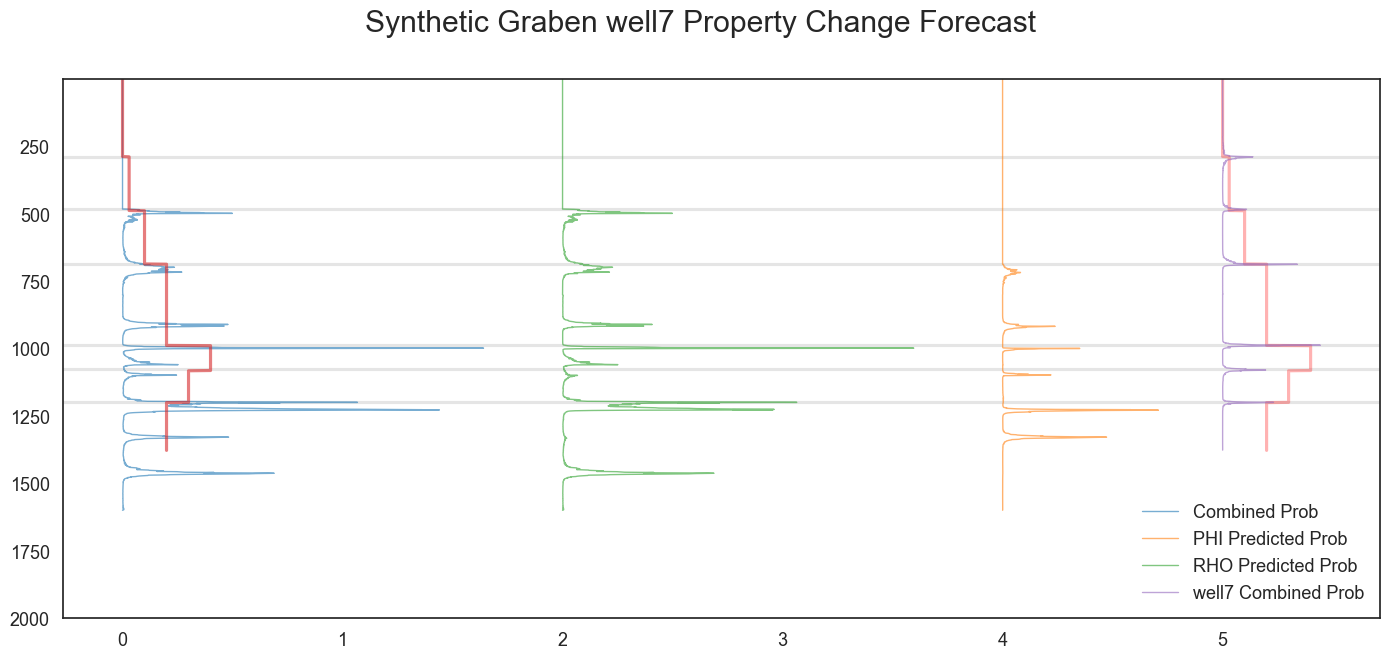

In [48]:
import matplotlib.animation as anim
fig, ax = plt.subplots(1, figsize=(17,7))
def syn_graben_anim(i):
    

    idx = np.linspace(300,1400, 50, dtype=int)

    print(idx[i])
    
    depth=idx[i]

    _log_list_ = ['RHO','PHI']
    _prob_list_ = ['CP_Prob_PHI','CP_Prob_RHO']

    _wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6', 'well7']
    _well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6, 'well7': well7}

    _logname_extent_min = {'well1': 0 ,'well2' : 0, 'well3' : 0 , 'well4': 0 , 'well5' : 0 , 'well6': 0, 'well7' :0 }
    _logname_extent_max = {'well1': 1600 ,'well2' : 1600, 'well3' : 1600 , 'well4': 1600 , 'well5' : 1075 , 'well6': 1497, 'well7' : depth }

    print(_logname_extent_max['well7'])
    peak_height= 0.07 #Probability threshold to qualify as a distinct changepoint

    for well in _wellnames_:
        for _log_choice, _prob_choice in zip(_log_list_, _prob_list_):

            locals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                        _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

            print(well+ '_'+ _log_choice + ' complete')
    
    # _log_list_ = ['RHO','PHI']
    # _prob_list_ = ['CP_Prob_PHI','CP_Prob_RHO']

    # _wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6', 'well7']
    # _well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6, 'well7': well7}

#peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

    operator = 'cosine'
    thresh = 0.997

    idx = np.linspace(300,1400, 50, dtype=int)

    print(idx[i])
    
    depth=idx[i]
    comparitee = 'well7'

    Tor = []

    for well in _wellnames_:
        for _prob_, _log_ in zip(_prob_list_,_log_list_):
            print(_prob_,_log_)
            Tee = locals()[comparitee+'_'+_log_+'_CPstats']
            Tor = locals()[well+'_'+_log_+'_CPstats']
    
            globals()[well+'_'+comparitee+'_'+_log_+'_prob_'] = cp_Comp.prob_cpCorr(Tee[:depth], Tor, operator=operator, thresh=thresh, df=_well_df_[well], log=_prob_)
    
    well7_probmatrix = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob_,
                                                         well2_well7_RHO_prob_,
                                                         well3_well7_RHO_prob_, 
                                                         well4_well7_RHO_prob_,
                                                         well5_well7_RHO_prob_, 
                                                         well6_well7_RHO_prob_,
                                                         well1_well7_PHI_prob_,
                                                         well2_well7_PHI_prob_,
                                                         well3_well7_PHI_prob_, 
                                                         well4_well7_PHI_prob_,
                                                         well5_well7_PHI_prob_, 
                                                         well6_well7_PHI_prob_)


    well7_probmatrixPHI = cp_Comp.combine_vectors_to_matrix_(well1_well7_PHI_prob_,
                                                         well2_well7_PHI_prob_,
                                                         well3_well7_PHI_prob_, 
                                                         well4_well7_PHI_prob_,
                                                         well5_well7_PHI_prob_, 
                                                         well6_well7_PHI_prob_)


    well7_probmatrixRHO = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob_,
                                                         well2_well7_RHO_prob_,
                                                         well3_well7_RHO_prob_, 
                                                         well4_well7_RHO_prob_,
                                                         well5_well7_RHO_prob_, 
                                                         well6_well7_RHO_prob_)

    well7_all_prob = cp_Comp.combine_vectors_to_matrix_(well7['CP_Prob_PHI'][:depth].values, well7['CP_Prob_RHO'][:depth].values)
    
    #print(well7_probmatrix)
    ax.clear()
    #fig, ax = plt.subplots(1, figsize=(17,7))
    #plt.figure(figsize=(10,15))
    ax.set_ylim(2000)
    #ax.set_xlim(25)
    #f11A_top10 = f11A_tops*10-26000 #25400
    #k=0
    for i in true_peaks:
        ax.axhline(i, alpha=0.1, color='k')#, color=f11A_color[k])#, label=f11A_FM[k])
        #print(k)
        #k=k+1
    ax.plot(np.sum(well7_probmatrix, axis=1), np.arange(len(well7_probmatrix)), linewidth=1, alpha=.6, label='Combined Prob' )
    ax.plot(np.sum(well7_probmatrixPHI, axis=1)+4, np.arange(len(well7_probmatrixPHI)), linewidth=1, alpha=.6, label = 'PHI Predicted Prob' )
    ax.plot(np.sum(well7_probmatrixRHO, axis=1)+2, np.arange(len(well7_probmatrixRHO)), linewidth=1, alpha=.6, label = 'RHO Predicted Prob' )
    ax.plot(OBSERwelldata[0][:depth], OBSERwellpath[:depth,2], alpha=0.6)
    ax.plot(5+np.array(OBSERwelldata[0][:depth]), OBSERwellpath[:depth,2], alpha=0.3, color='r')

    ax.plot(np.sum(well7_all_prob, axis=1)+5, np.arange(len(well7_all_prob)), linewidth=1, alpha=0.6, label='well7 Combined Prob')
    maxx = len(well7)

    #fig.set_tight_layout()
    fig.suptitle('Synthetic Graben well7 Property Change Forecast')
    #f11A_top10
    #cmap = plt.colormaps('turbo')


    plt.legend(loc='lower right', frameon=False)
    #fig.canvas.draw()
    return fig, 

grab_anim = anim.FuncAnimation(fig, syn_graben_anim,
    frames = 49, interval = 100, blit = True)

# = anim.ArtistAnimation(fig, plot_all, frames=400, interval = 80, blit=True)
grab_anim.save('syn_grab_anim_3.mp4', writer = 'ffmpeg', fps = 8)


In [459]:
# #syn_graben_anim(19)
# #%matplotlib notebook
# grab_anim = anim.FuncAnimation(fig, syn_graben_anim,
#     frames = 49, interval = 100, blit = True)

# # = anim.ArtistAnimation(fig, plot_all, frames=400, interval = 80, blit=True)
# grab_anim.save('syn_grab_.mp4', writer = 'ffmpeg', fps = 8)
# #plt.plot(OBSERwelldata[0][:400], OBSERwellpath[:400,2], alpha=0.6)